# Using initial depletion calculations, we can relate depletion to pumping rates to calculate Depletion Potential for each well. We will also look at this information spatially

In [1]:
import yaml
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append('../scripts')
from wdnr_pycap import Excel2YML
import pyemu
import matplotlib.pyplot as plt
import os, platform
from pycap.analysis_project import Project
import geopandas as gpd
from shapely.geometry import Point
from  datetime import date


In [5]:
#### Path to excel input file. Note can use absolute or relative path.
pycap_inputs_excel = Path("../../PyCap/PyCap_USGS/pycap-dss2/Notebooks/Inputs/LPR_Prepped.xlsx")

#### PyCap Run Name is what all your outputs will have as a name. 
pycap_run_name = "LPR_Redux"

#### Base directory for runs
parent_run_path = Path("../pycap_runs")

#### depletion potential calculations directory

base_run_path = parent_run_path / "pycap_base"
depletion_potential_path = parent_run_path / "pycap_dp"

Reviewer_Name = "MNF"


In [6]:
if not depletion_potential_path.exists():
    depletion_potential_path.mkdir(parents=True)

### First we will need all the information from the model input (for locations and Q data)

In [13]:
with open(base_run_path / "LPR_redux.yml", "r") as ifp:
    indat = yaml.safe_load(ifp)

## Now it would be conventient to make a GeoDataFrame of the input

### quick note - streamflow is in CFS but Q is reported in GPM, so to calculate ratios, we need to convert (beware smashing [Mars Rovers](https://en.wikipedia.org/wiki/Mars_Climate_Orbiter)!) and the conversion from GPM to CFS is:
$1 CFS = 1 GPM=\frac{G}{M}\times\frac{1ft^3}{7.48052G}\times\frac{1M}{60S}$  
$1 CFS = 0.002228 \times 1 GPM$

In [41]:
GPM2CFS = 1/7.48052/60

In [43]:
indcol = [i for i in indat.keys() if 'well' in i.lower()]
names = [indat[i]['name'] for i in indcol]
locs = [Point(-indat[i]['loc']['x'],indat[i]['loc']['y']) for i in indcol]
Q = [indat[i]['Q'] for i in indcol]

wells_gdf = gpd.GeoDataFrame(index = indcol, data={"name":names, 
                                                   "Q_gpm":Q, 
                                                   "Q_cfs": [Qi*GPM2CFS for Qi in Q],
                                                   "geometry":locs}, crs=4326)

In [45]:
wells_gdf.explore()

### Load in the results file

In [37]:
depl = pd.read_csv(
    base_run_path / f"output/{pycap_run_name}.table_report.base_stream_depletion.csv", index_col = 0
)
depl

,LPR
418,8.696664e-03
466,4.548644e-01
467,3.569738e-01
490,7.699735e-13
509,2.303785e-07
...,...
94988,1.201666e-08
95068,5.519772e-06
total_proposed,8.696664e-03
total_existing,5.501314e+00


### Now join this into the wells GeoDataFrame

In [54]:
wells_gdf = wells_gdf.merge(depl.LPR, 
                left_on = "name", 
                right_index=True).rename(columns={"LPR":"DEPL_cfs"})

In [56]:
wells_gdf["Depletion_Potential"] = wells_gdf["DEPL_cfs"]/wells_gdf["Q_cfs"]

In [73]:
wells_gdf.explore(column="Depletion_Potential",
                  vmin=0,vmax=1,
                  style_kwds={"style_function":
                                  lambda x: 
                                  {"radius":x["properties"]["Depletion_Potential"]*15}})


<Axes: >

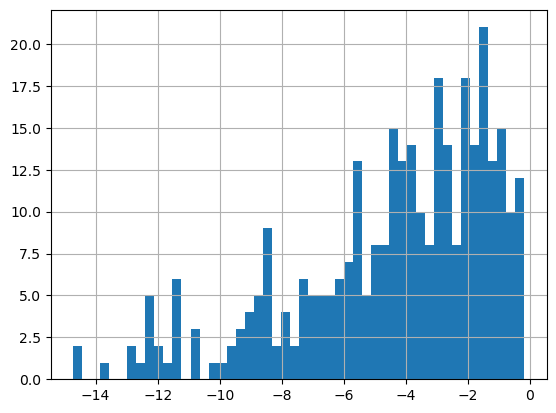

In [72]:
wells_gdf.Depletion_Potential.apply(np.log10).hist(bins=50)